In [7]:
from scipy.optimize import minimize
import scipy
import os
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from itertools import product
import numpy as np
import warnings
import shapely
import cdsapi
import datetime
warnings.filterwarnings("ignore")

#--------------------- INSAR4SM functionalities --------------
from insar4sm.classes import INSAR4SM_stack, SM_point
from insar4sm.gridding import WGS84_to_UTM
from insar4sm.prep_meteo import convert_to_df

In [8]:
def rewrap(data:np.array)-> np.array:
    """Wraps the data between -pi and pi.

    Args:
        data (np.array): the data need to be wrapped

    Returns:
        np.array: Wrapped data. Values are between -pi and pi
    """
    return data - np.round(data/2.0/np.pi)*2.0*np.pi

### Download ERA5 observations

In [12]:
c = cdsapi.Client()

c.retrieve(
    'reanalysis-era5-land',
    {   
        'variable': ['volumetric_soil_water_layer_1'],
        'year': ['2017', '2018', '2019'],
        'month': ['01','02','03','04','05','06','07','08','09','10','11','12'],
        'day': [
            '01', '02', '03',
            '04', '05', '06',
            '07', '08', '09',
            '10', '11', '12',
            '13', '14', '15',
            '16', '17', '18',
            '19', '20', '21',
            '22', '23', '24',
            '25', '26', '27',
            '28', '29', '30',
            '31',
        ],
        'time': ['01:00','05:00','09:00', '14:00', '19:00','23:00'],
        'area': [
            19.15, 56.52, 18.9,
            56.82,
        ],
        'format': 'netcdf',
    },
    '/Lamabot1/Rowena_2023/Comparison/ERA5/era5_ssm.nc')

2023-05-16 21:20:40,548 INFO Welcome to the CDS
2023-05-16 21:20:40,549 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-land
2023-05-16 21:20:40,698 INFO Request is queued
2023-05-16 21:20:41,739 INFO Request is running
2023-05-16 21:39:01,099 INFO Request is completed
2023-05-16 21:39:01,101 INFO Downloading https://download-0013-clone.copernicus-climate.eu/cache-compute-0013/cache/data2/adaptor.mars.internal-1684262251.884134-7270-3-b7debfe0-b0dc-42fe-9c9c-c4d91f074516.nc to /Lamabot1/Rowena_2023/Comparison/ERA5/era5_ssm.nc (180.7K)
2023-05-16 21:39:01,536 INFO Download rate 416.5K/s


Result(content_length=185080,content_type=application/x-netcdf,location=https://download-0013-clone.copernicus-climate.eu/cache-compute-0013/cache/data2/adaptor.mars.internal-1684262251.884134-7270-3-b7debfe0-b0dc-42fe-9c9c-c4d91f074516.nc)

In [13]:
def create_buffer_poly(ISMN_station_file: str, grid_size: float, save: bool = True ) -> shapely.geometry.polygon.Polygon:

    # convert wgs geometry to projection system

    ISMN_station_loc_wgs84 = gpd.read_file(ISMN_station_file)
    ISMN_station_loc_wgs84.crs = "EPSG:4326"

    lon = ISMN_station_loc_wgs84['geometry'][0].x
    lat = ISMN_station_loc_wgs84['geometry'][0].y
    utm_crs_epsg = WGS84_to_UTM(lon, lat)    

    ISMN_station_loc_UTM = ISMN_station_loc_wgs84.to_crs(epsg=utm_crs_epsg).iloc[0].geometry

    ISMN_station_loc_UTM_buffer = ISMN_station_loc_UTM.buffer(grid_size, cap_style = 1)

    ISMN_station_loc_buffer = gpd.GeoDataFrame(index=[0], crs=utm_crs_epsg, geometry=[ISMN_station_loc_UTM_buffer])

    ISMN_station_loc_buffer = ISMN_station_loc_buffer.to_crs(epsg=4326)

    if save:
        save_dir = os.path.dirname(ISMN_station_file)
        filename = os.path.join(os.path.basename(ISMN_station_file).split('.')[0]+'_'+str(grid_size)+'.geojson')
        ISMN_station_loc_buffer.to_file(os.path.join(save_dir,filename), driver="GeoJSON")  

    return ISMN_station_loc_buffer.geometry

### Load data

In [14]:
projectname = 'Test_Lohman_Burgi'
grid_size = 100
orbit_time_UTC = '14:00:00'
# the directory of the topstack processing
topstackDir = '/Lamabot1/Rowena_2023/Topstack_arabia_130/'

# the AOI geojson file for your project
# ensure that AOI is inside your topstack stack
AOI = '/Lamabot1/Rowena_2023/AOI/arabia_burgi_2023.geojson'

# the meteorological file. You can either provide an ERA5-land file or a csv file with 3 columns (Datetimes, tp__m, skt__K).
meteo_file = '/Lamabot1/Rowena_2023/Comparison/ERA5/era5_tp.nc'
# set to True in case you provide an ERA5-Land file
ERA5_flag = True
# In case you downloaded surface soil moisture from ERA5-land, set to True for comparison purposes
ERA5_sm_flag = True

# the output directory 
export_dir = '/Lamabot1/Rowena_2023/Comparison/'

# soil information datasets (https://soilgrids.org/)
sand_soilgrids = '/Lamabot1/Rowena_2023/Comparison/sand_burgi_2023.tif'
clay_soilgrids = '/Lamabot1/Rowena_2023/Comparison/sand_burgi_2023.tif'

# geometrical infromation regarding ISMN station
comparison_point_loc = '/Lamabot1/Rowena_2023/Comparison/comparison_point.geojson'

#IMSN_polygon = gpd.read_file('/RSL02/SM_NA/ISMN/{}/{}_neighborhood.geojson'.format(station_name, station_name))['geometry']

comparison_polygon = create_buffer_poly(comparison_point_loc, grid_size)

comparison_point = comparison_polygon.centroid

stack = INSAR4SM_stack(topstackDir = topstackDir,
                    projectname = projectname,
                    AOI = AOI,
                    meteo_file = meteo_file,
                    ERA5_flag = ERA5_flag,
                    sand = sand_soilgrids,
                    clay = clay_soilgrids,
                    orbit_time = orbit_time_UTC,
                    export_dir = export_dir)

stack.prepare_datasets()
stack.plot()
stack.get_dry_SARs()
stack.calc_insar_stack()

stack.sm_points = comparison_point
stack.sm_polygons = comparison_polygon
stack.n_sm_points = len(stack.sm_points)

number of SLCs discovered:  60
directory "/Lamabot1/Rowena_2023/Comparison//Test_Lohman_Burgi/INSAR4SM_datasets/slcs" already exists.
write vrt file for each SLC ...
stack directory: /Lamabot1/Rowena_2023/Comparison//Test_Lohman_Burgi/INSAR4SM_datasets/coreg_stack already exists
write vrt file for stack directory
directory /Lamabot1/Rowena_2023/Comparison//Test_Lohman_Burgi/INSAR4SM_datasets/geometry already exists.
write vrt file for geometry dataset


Text(0, 0.5, 'ERA5-land volumetric SSM (m3/m3)')

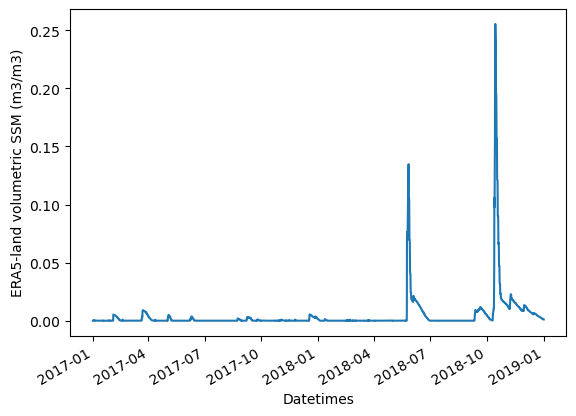

In [51]:
meteo_df = convert_to_df('/Lamabot1/Rowena_2023/Comparison/ERA5/era5_ssm.nc', AOI, ERA5_flag)
meteo_df.index = pd.to_datetime(meteo_df.index)

sel_datetimes = [slc_datetime + datetime.timedelta(hours=14) for slc_datetime in pd.to_datetime(stack.slc_datetimes)]

comparison_df = pd.DataFrame()
comparison_df.index = sel_datetimes
comparison_df['swvl1__m**3 m**-3'] = (meteo_df.loc[sel_datetimes]['swvl1__m**3 m**-3']*100).copy().to_frame()

meteo_df['swvl1__m**3 m**-3']['20170101':'20181231'].plot()
plt.ylabel('ERA5-land volumetric SSM (m3/m3)')

Text(0, 0.5, 'ERA5-land precipitation (m)')

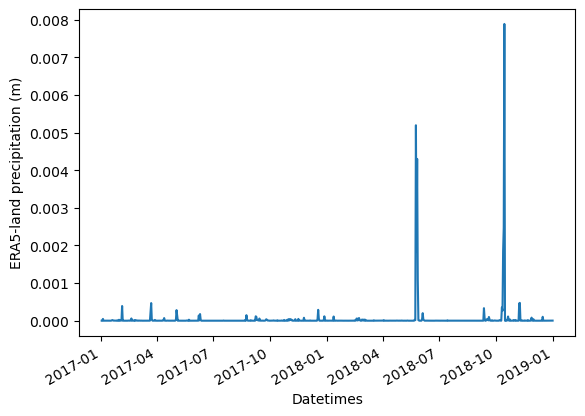

In [26]:
precipitation_df = convert_to_df('/Lamabot1/Rowena_2023/Comparison/ERA5/era5_tp.nc', AOI, ERA5_flag)
precipitation_df.index = pd.to_datetime(precipitation_df.index)

sel_datetimes = [slc_datetime + datetime.timedelta(hours=14) for slc_datetime in pd.to_datetime(stack.slc_datetimes)]

precipitation_df['tp__m']['20170101':'20181231'].plot()
plt.ylabel('ERA5-land precipitation (m)')

$
     \hat{\gamma_j}(t_a, t_b) = \frac{\sum_{l=1}^{N} u_l(t_a)u_j(t_b)^{*}}{\sqrt{\sum_{l=1}^{N} \lvert u_l(t_a) \rvert^2}\sqrt{\sum_{l=1}^{N} \lvert u_l(t_b) \rvert^2}} 
$

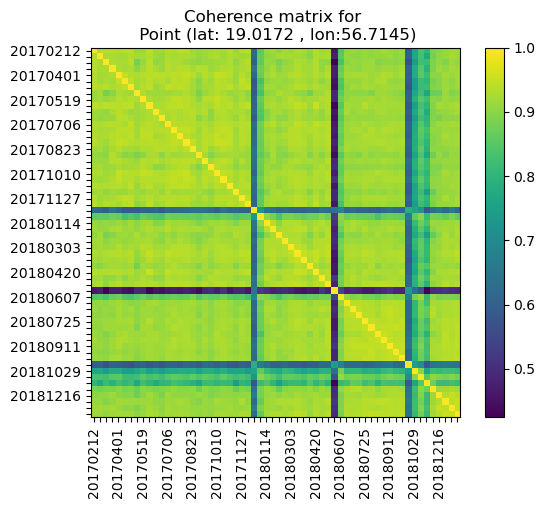

In [27]:
sm_point_no_DS_ts = SM_point(stack, sm_ind=0)
sm_point_no_DS_ts.amp_sel = False
sm_point_no_DS_ts.get_DS_info(stack)
sm_point_no_DS_ts.calc_covar_matrix()
# Coherence information
coh = sm_point_no_DS_ts.coh_full_DS[0,:,:].copy()
plt.imshow(coh); plt.colorbar()
plt.title("Coherence matrix for \n Point (lat: 19.0172 , lon:56.7145)")

ticks = np.full(len(stack.slc_datetimes), '', dtype=np.dtype('<U16'))
for i in range(0, 60, 4):
    ticks[i] = stack.slc_datetimes[i].date().strftime("%Y%m%d")

plt.xticks(ticks = range(0,60) ,labels = ticks, rotation = 'vertical')
plt.yticks(ticks = range(0,60) ,labels = ticks, rotation = 'horizontal')
plt.show()

Find the indices of the pixel that covers the given point of interest and get the **raw slc values**

In [28]:
Point_lon = gpd.read_file(comparison_point_loc).geometry.x.values
Point_lat = gpd.read_file(comparison_point_loc).geometry.y.values
Point_image_flat_coords = np.argmin(np.abs(stack.lon_data-Point_lon)+np.abs(stack.lat_data-Point_lat))
Point_image_xy = np.unravel_index(Point_image_flat_coords, stack.lon_data.shape)
raw_slc_values = stack.slc_stack[:,Point_image_xy[0],Point_image_xy[1]]

Calculate the **high pass phase component** by subtracting the raw interferometric phase values of the point of interest from phase of the complex interferometric coherence

In [29]:
n_dates = len(sm_point_no_DS_ts.slc_dates)
high_pass_phase = np.full((n_dates,n_dates), np.nan, dtype=np.float32)

for i in range(n_dates):
    for j in range(i, n_dates):
        raw_phase_diff = raw_slc_values[i] * np.conjugate(raw_slc_values[j])
        averaged_phase = sm_point_no_DS_ts.DS_Covar[i,j]
        phase_diff_value = np.angle(averaged_phase)-np.angle(raw_phase_diff)
        high_pass_phase[i,j] = rewrap(phase_diff_value)

Plotting high pass phase component

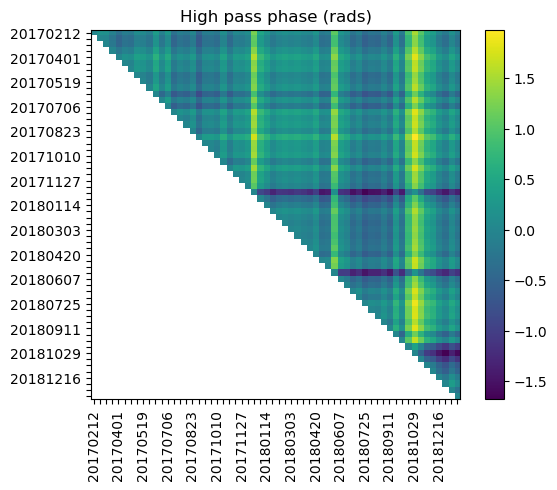

In [30]:
plt.imshow(high_pass_phase)
plt.title('High pass phase (rads)')
plt.colorbar()
ticks = np.full(len(stack.slc_datetimes), '', dtype=np.dtype('<U16'))
for i in range(0, 60, 4):
    ticks[i] = stack.slc_datetimes[i].date().strftime("%Y%m%d")

plt.xticks(ticks = range(0,60) ,labels = ticks, rotation = 'vertical')
plt.yticks(ticks = range(0,60) ,labels = ticks, rotation = 'horizontal')
plt.show()

Calculate the phase closure array at n=12 days. Eq 5

$ T_n(t_a, t_b) = arg [ \hat{\gamma}_j(t_b, t_a)^*\prod_{k=1}^{(t_b-t_a)/n}\hat{\gamma}_j(t_a + kn, t_a + (k-1)n)] $

In [31]:
def ph_closure_combs(n_days:int, covar:np.array, slc_datetimes:pd.core.indexes.datetimes.DatetimeIndex):
    n_dates = len(slc_datetimes)
    T_n = np.full((n_dates,n_dates), np.nan, dtype=np.float32)
    
    for start_ind, start_t in enumerate(slc_datetimes):
        for end_local_ind, end_t in enumerate(slc_datetimes[start_ind+1:]):
            end_ind = end_local_ind + start_ind + 1
            if (end_t-start_t).days > n_days:
                single_coh = covar[start_ind, end_ind]
                product_coh = np.ones(1, dtype=complex)
                for ind in range(start_ind, end_ind):
                    temp_coh = covar[ind, ind+1]
                    product_coh *= temp_coh

                T_n[start_ind, end_ind] = np.angle(single_coh*np.conjugate(product_coh))
    return T_n

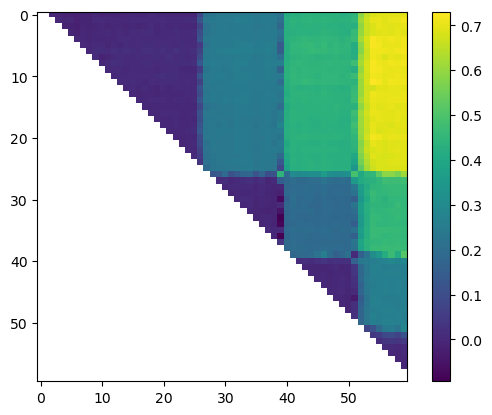

In [32]:
T_n = ph_closure_combs(n_days = 12, covar = sm_point_no_DS_ts.DS_Covar, slc_datetimes = sm_point_no_DS_ts.slc_dates)
plt.imshow(T_n)
plt.colorbar()

In [34]:
sm_point_no_DS_ts.get_DS_geometry(stack)
bperp = sm_point_no_DS_ts.DS_bperp
coh = sm_point_no_DS_ts.coh_full_DS[0,:,:]
n_bands = len(sm_point_no_DS_ts.slc_dates)
coh_baseline_list = []

for i in range(n_bands):
    for j in range(i+1, n_bands):
        baseline_temp = bperp[i]-bperp[j]
        coh_temp = coh[i,j]
        coh_baseline_list.append([baseline_temp, coh_temp])

coh_baseline_df = pd.DataFrame(coh_baseline_list, columns=['Perp_Baseline','Coherence'])

Text(0, 0.5, 'Coherence')

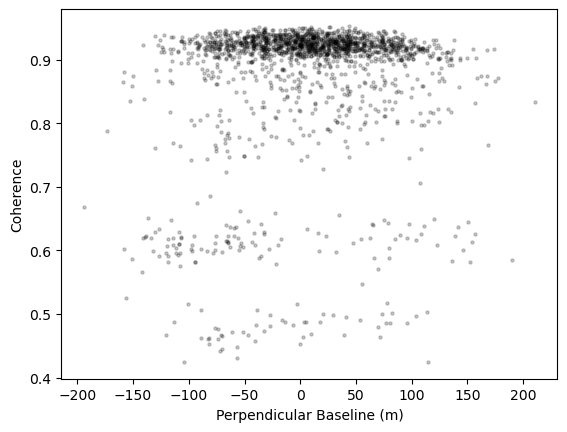

In [35]:
plt.scatter(coh_baseline_df.Perp_Baseline, coh_baseline_df.Coherence, s=20, c='black', marker='.', alpha=0.2)
plt.xlabel('Perpendicular Baseline (m)')
plt.ylabel('Coherence')

### Plotting log transformed coherence information
All log transformed values are negative because coherence ranges from 0 to 1.

Text(0.5, 1.0, 'Coherence matrix (log transformed)')

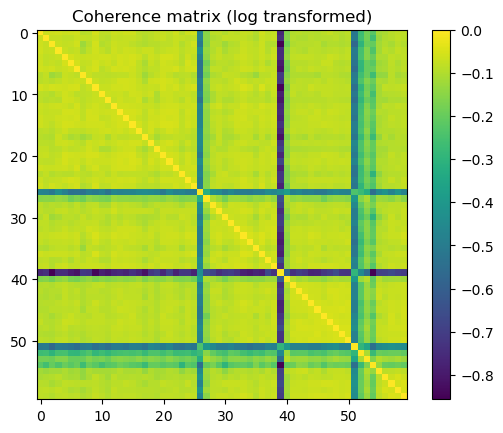

In [36]:
coh[coh < 0.02] = np.nan
log_coh = np.log(coh)
plt.imshow(log_coh); plt.colorbar()
plt.title("Coherence matrix (log transformed)")

#### The observed coherence loss between any two dates at a location can be approximated as a product of four components: a background coherence term (constant in time) that is determined by factors that include surface roughness and surface slope, permanent coherence change due to disturbance or movement of material within a pixel during a given time interval, transient coherence change that involves a dependence on soil moisture, and a term related to satellite viewing geometry changes.

$γ_{ij}=γ_{ij}^{0} γ_{ij}^{p} γ_{ij}^{s} γ_{ij}^{B}$ &emsp; Eq 1

where $γ^0$ is the “background” coherence due to surface roughness, slope, etc.,$γ_{ij}^p$ is the “permanent” coherence loss spanning the time interval between dates $i$ and $j$, and $γ_{ij}^s$ the “transient” coherence loss that is due to the difference in soil moisture between two dates. $γ_{ij}^B$ is a term dependent on the component of the spatial baseline between the two satellite-based observation locations that is perpendicular to the viewing direction.  

For flat terrain, this term scales linearly with the ratio between the perpendicular baseline and the critical baseline (e.g., Zebker &
Villasenor, 1992), which, is > 5 km for the Sentinel-1 satellites. For the <∼200 m perpendicular baselines used in this study, this effect would contribute only < 0.04 to the largest-baseline interferograms. Volume scattering could increase this amount, but we do not observe any appreciable difference from the flat terrain model in our data, so we neglect $γ_{ij}^B$ in the analysis that follows. Seasonal changes in vegetation would impact the transient term, but that is not a factor in this hyperarid study area.

### Finding initial value of $γ^0$ (minimum log-transformed coherence value)

In [37]:
log_gamma_0 = np.nanmin(log_coh)
print(" The initial value of 'background' coherence (log transformed) is {:.2f}".format(log_gamma_0))
print(" In coherence units (0-1) is {:.2f}".format(np.exp(log_gamma_0)))

 The initial value of 'background' coherence (log transformed) is -0.86
 In coherence units (0-1) is 0.42


The “permanent” coherence loss term is associated with individual time intervals and accumulates over time, such that values of $γ_{ij}^p$ for longer-timescale interferometric pairs are the product of the permanent coherence loss within all of the intervening time intervals:

$log(γ_{ij}^p) = \sum_{k=i}^{j-1} log(γ_{k,k+1}^p)$ &emsp; Eq 2

### Finding initial values of $γ_{ij}^p$ this component for each time interval must be no larger than the smallest (worst) value found in any interferogram of any timespan that includes that time interval.

In [38]:
def getIncludedInts(start_ind, end_ind, min_ind, max_ind):
  '''
  Functionality that given the interferogram it returns the interferograms that 
  is included. For example interferogram 1-2 is included in all interferograms 
  that start with less or equal that 1 and end with big or equal that 2.
  '''
  good_start_inds = range(min_ind,start_ind+1)
  good_end_inds = range(end_ind,max_ind+1)
  good_combs = list(product(list(good_start_inds),list(good_end_inds)))
  return good_combs

In [39]:
def get_gamma_p_value(start_ind, end_ind, log_coh):
  '''
  Functionality that given start/end indices of interferogram, returns the 
  minimum value of all the interferograms that include the given interferogram.
  '''
  min_ind=0
  max_ind=log_coh.shape[0]-1
  assert log_coh.shape[0] == log_coh.shape[1]
  good_combs = getIncludedInts(start_ind, end_ind, min_ind, max_ind)
  good_combs.append((start_ind, end_ind))
  coh_cand_values = [log_coh[row,col] for row,col in good_combs]
  log_gamma_p = np.nanmin(coh_cand_values)
  return log_gamma_p

In [40]:
nbands = log_coh.shape[0]
num_tri_elements = np.triu_indices_from(log_coh,1)[0].shape[0]
row, col = np.triu_indices_from(log_coh,1)
log_gamma_p_dataset = np.zeros(num_tri_elements, dtype = np.float64)

# we initialize with raw coherence values
for ind in range(num_tri_elements):
    log_gamma_p_dataset[ind] = get_gamma_p_value(row[ind], col[ind], log_coh)

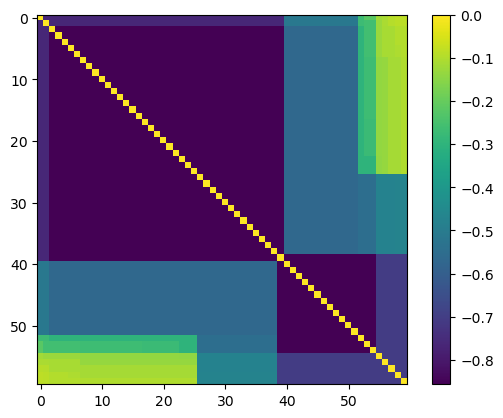

In [41]:
initial_p_values = np.zeros_like(coh)
for ind in range(log_gamma_p_dataset.shape[0]):
    ind1 = row[ind]
    ind2 = col[ind]
    initial_p_values[ind1, ind2] = log_gamma_p_dataset[ind]
    initial_p_values[ ind2, ind1] = log_gamma_p_dataset[ind]
plt.imshow(initial_p_values)
plt.colorbar()

Because the coherence depends on the difference in soil moisture between two dates, not on its absolute value, we also define $s_i$, a “soil moisture index” for each date, $i$, and define the transient term based on the difference between this index on the two dates:

$log(γ_{ij}^s) = -abs(log(s_i)-log(s_j))$ &emsp; Eq 3

Note the ambiguity in sign and mean value for the full time series of $s_i$. We could arbitrarily shift the entire time series of $s_i$ by a constant or multiply by −1 without changing the predicted impact on coherence. We choose the
convention that the dry values of $s_i$ are near zero, and the wet values are higher, approaching unity. Both a dry-dry pair and a wet-wet pair would be expected to have higher coherence than a pair between dates with differing soil
moisture.

The solution to the nonlinear set of equations in Equations 1-3 can be more easily found by taking the log of all values in Equation 1:

$log(γ_{ij})=log(γ_{ij}^{0})+log( γ_{ij}^{p})+ log(γ_{ij}^{s})+log( γ_{ij}^{B})$ &emsp; Eq 4


We then note that the background coherence term, $γ^0$, can be no worse than the lowest coherence found in the entire set of interferograms. Similarly, $γ_{ij}^p$ for each time interval must be no larger than the smallest (worst) value found in any interferogram of any timespan that includes that time interval. We solve the system of equations within Equations 2–4 using an iterative approach where we assign initial values of $γ^0$ and $γ_{ij}^p$ based on the above-mentioned maximum values, and then remove the prediction of coherence loss due to those terms from the set of coherence values for that pixel.

### Plotting initial $\gamma_p$ values

### We calculate the mean permanent coherence of the interferograms that share the same starting date

Text(0.5, 1.0, 'The mean permanent coherent for each starting date.')

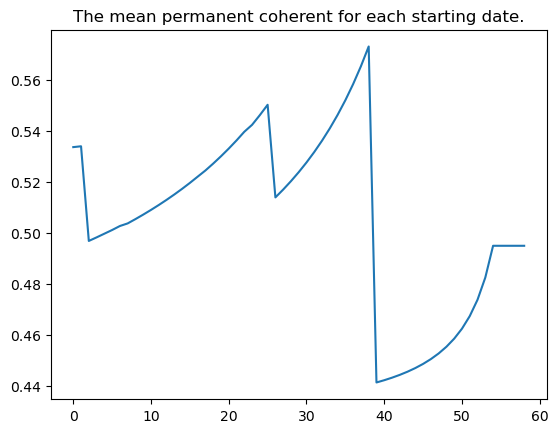

In [42]:
log_gamma_p_mean = np.zeros(nbands)
log_gamma_p_df = pd.DataFrame([row, col, log_gamma_p_dataset]).T
log_gamma_p_mean = log_gamma_p_df.groupby([0]).mean()[2].values

plt.plot(np.exp(log_gamma_p_mean))
plt.title('The mean permanent coherent for each starting date.')

### We calculate the indices of all interferograms that will be replaced by the mean permanent coherence values

In [43]:
mean_to_initial_index = log_gamma_p_df.index.to_series().groupby(log_gamma_p_df[0]).unique().to_numpy()
print ("For example the interferograms with indices that include SAR image 1 {} \n will have the same permanent coherence value with the mean permanent coherence value of the SAR image 1: {}".format(mean_to_initial_index[0], log_gamma_p_mean[0]))


For example the interferograms with indices that include SAR image 1 [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58] 
 will have the same permanent coherence value with the mean permanent coherence value of the SAR image 1: -0.627904501850041


$log(γ_{ij}^*)=log(γ_{ij})-log(γ^{0*}) - log(γ_{ij}^{p*})$ &emsp; Eq 5


Where $log(γ^{0*})$ and $log(γ_{ij}^{p*})$ are the initial predictions of those terms. We then perform a nonlinear inversion for the values for $s_i$ that best fit $log(γ_{ij}^*)$, using the relationship in Equation 3 and the average of the corrected coherence terms that include each date as our starting point.

We find that this approach converges to the same values as is achieved with more traditional nonlinear approaches over all of the unknown parameters, such as conjugate-gradient approaches with multiple starting points (e.g., Fletcher, 1964).

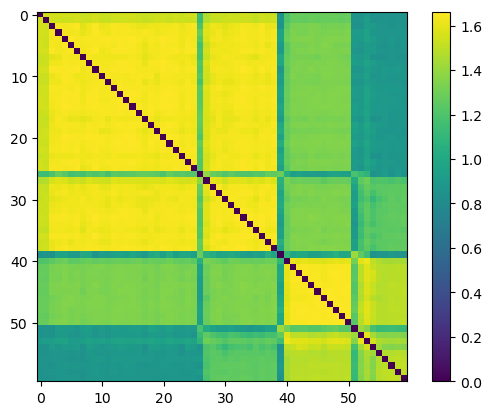

In [44]:
log_gamma_star = np.zeros(num_tri_elements, dtype = np.float64)
for ind in range(num_tri_elements):
    log_gamma_star[ind] = log_coh[row[ind], col[ind]]-log_gamma_0-log_gamma_p_dataset[ind]

# # plotting gamma_star
gamma_star = np.zeros_like(coh)
for ind in range(log_gamma_star.shape[0]):
    ind1 = row[ind]
    ind2 = col[ind]
    gamma_star[ind1, ind2] = log_gamma_star[ind]
    gamma_star[ ind2, ind1] = log_gamma_star[ind]

plt.imshow(gamma_star)
plt.colorbar()

Restructuring coherence observations [nbands x nbands] - > nbands(nbands-1)/2

In [45]:
nbands = log_coh.shape[0]
num_tri_elements = np.triu_indices_from(log_coh,1)[0].shape[0]
row, col = np.triu_indices_from(log_coh,1)
log_gamma_obs = np.zeros(num_tri_elements, dtype = np.float64)

for ind in range(num_tri_elements):
    log_gamma_obs[ind] = log_coh[row[ind], col[ind]]

### Initialization

In [53]:
# initial values of SM
nbands=log_coh.shape[0]
X_SM = np.random.normal(0.05, 0.05, nbands)
X_SM = np.clip(X_SM, 0.01, 0.99)

# X_SM = comparison_df['swvl1__m**3 m**-3']/100
# n_dry_bands = np.sum(X_SM<0.01)
# X_SM[X_SM<0.01] = np.random.normal(0.01, 0.001, n_dry_bands)


# initial values of permanent coherence (log transformed)
X_log_gamma_p_mean = log_gamma_p_mean.copy()

# initial values of background coherence
X_log_gamma_0 = log_gamma_0

X = np.hstack([X_SM, X_log_gamma_p_mean, X_log_gamma_0])
print("Initial values of unknowns.")
print("The first {} elements represent Soil moisture. ".format(nbands))
print (X[:nbands])
print("The next {} elements represent mean value of permanent coherence.".format(X_log_gamma_p_mean.shape[0]))
print (X[nbands:2*nbands-1])
print("The last one represent background coherence")
print(X[-1])

Initial values of unknowns.
The first 60 elements represent Soil moisture. 
[0.11478975 0.16063924 0.04713993 0.01       0.09467585 0.07858823
 0.01159899 0.05500219 0.06447897 0.04567274 0.05210881 0.10133048
 0.08797295 0.01       0.13071486 0.01       0.10385701 0.07957511
 0.0325331  0.02648979 0.0725787  0.10665502 0.16434962 0.08733487
 0.01471825 0.01       0.06410464 0.03347701 0.03653782 0.01348978
 0.1179496  0.08992427 0.06854959 0.01164359 0.10984065 0.0239206
 0.09577729 0.01       0.05152772 0.01       0.03576065 0.16487028
 0.01       0.011702   0.0922579  0.02542697 0.09085428 0.02378168
 0.07998299 0.02854451 0.09608303 0.08948796 0.04785411 0.01
 0.08662765 0.03066579 0.03106361 0.06720387 0.06102435 0.06344828]
The next 59 elements represent mean value of permanent coherence.
[-0.6279045  -0.62728301 -0.69933548 -0.69653262 -0.69362784 -0.69073913
 -0.68761543 -0.68558844 -0.68224124 -0.67876015 -0.67513698 -0.67136284
 -0.66742809 -0.66332228 -0.65903398 -0.65455076

Bounds

In [54]:
bounds_SM = (0,1)
bound_log_coh = (-9999999,0)
bounds = []
for element in range(nbands):
    bounds.append(bounds_SM)
for element in range(nbands):
    bounds.append(bound_log_coh)

Objective function

In [55]:
def calc_gamma_t(SM):
  '''
  Calculate the modelled gamma transient (log transformed)
  given the soil moisture values
  '''
  nbands=SM.shape[0]
  temp_matrix = np.zeros((nbands,nbands))
  num_tri_elements = np.triu_indices_from(temp_matrix,1)[0].shape[0]
  log_gamma_t_modelled = np.zeros(num_tri_elements, dtype=np.float64)
  row, col = np.triu_indices_from(temp_matrix,1)
  for ind in range(num_tri_elements):
    # equation 3
    log_gamma_t_modelled[ind] = -np.abs(np.log(SM[row[ind]])-np.log(SM[col[ind]]))
  return log_gamma_t_modelled

In [56]:
def objective_function2(X):  
    '''
    Minimizes the difference between the modelled and observed transient 
    coherence (log transformed).        
    '''
    # X vector contains SM, gamma_permanent and gamma_background coherence
    nbands=int(X.shape[0]/2)
    SM0=X[:nbands]
    log_gamma_p_means = X[nbands:2*nbands-1]
    log_gamma_0 = X[-1]

    # reconstruction of initial shape of gamma_permanent matrix
    temp_matrix = np.zeros((nbands,nbands))
    num_tri_elements = np.triu_indices_from(temp_matrix,1)[0].shape[0]

    log_gamma_p_initial = np.zeros(num_tri_elements)
    for ind, log_gamma_p_mean in enumerate(mean_to_initial_index):
      log_gamma_p_initial[log_gamma_p_mean] = log_gamma_p_means[ind]

    log_gamma_t_obs = log_gamma_obs - log_gamma_p_initial - log_gamma_0
    log_gamma_t_model = calc_gamma_t(SM=SM0) 
    residual_matrix = log_gamma_t_obs-log_gamma_t_model
    cost =  np.sqrt(np.nansum(np.power(residual_matrix,2)))
    return cost

In [61]:
results = minimize(objective_function2,  X, options={'maxiter':1000}, method='SLSQP', bounds = bounds)

Text(0.5, 1.0, 'RMSE: 31.06 m3/m3 \n R : -0.72')

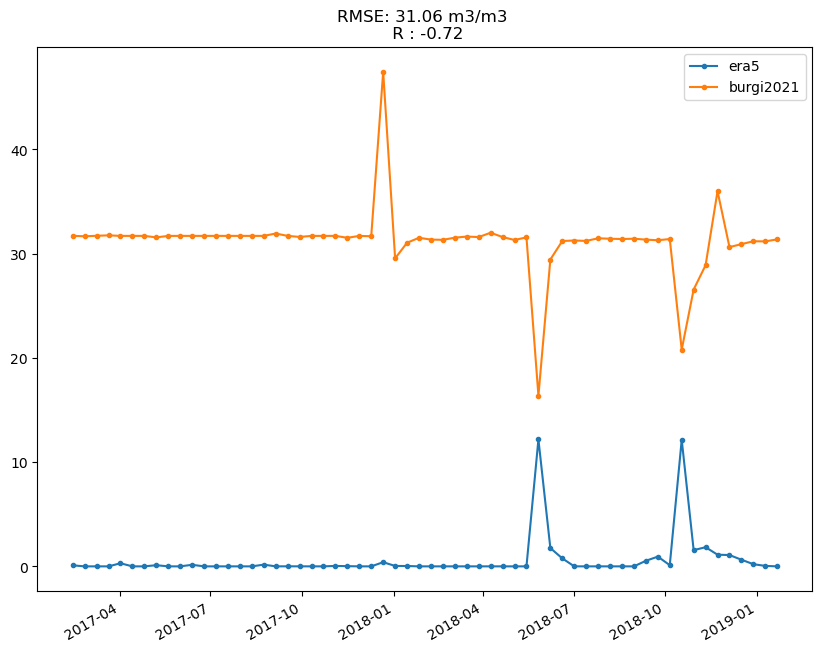

In [62]:
sm_estimations_df = comparison_df.copy()
sm_estimations_df['burgi2021'] = results['x'][:nbands]*100
sm_estimations_df['era5'] = sm_estimations_df['swvl1__m**3 m**-3']

predictions = sm_estimations_df.burgi2021
targets = sm_estimations_df.era5
n = predictions.shape[0]
rmse = np.linalg.norm(predictions - targets) / np.sqrt(n)
r, p = scipy.stats.pearsonr(predictions, targets)

sm_estimations_df[['era5', 'burgi2021']].plot(figsize=(10,8), style='.-')
plt.title('RMSE: {} m3/m3 \n R : {}'.format(round(rmse,2), round(r,2)))